# GPT-1 한국어 챗봇 프로젝트

  - Transformer와 비교
  - 공백, 특수문자 전처리
  - 모델의 입력 블럭을 GPT 논문에 기반하여 수정
  - GPT 모델을 정상적으로 구성
  - 입력에 따른 출력 생성

### 변경이 필요한 부분

  - 인코더가 없음
    - 모든 입력이 디코더로 들어간다
    - 인코더의 어텐션을 거친 출력이 없음
    - QnA형식의 입력을 delimiter로 연결해 입력해야함.
    - 추론단계에도 디코더만 써야함
  - 디코더 블록 내부 구조
    - 마스크드 멀티헤드 셀프 어텐션 층이 하나
    - ~~완전연결 대신 1D-합성곱 층 사용~~
  - 드롭아웃 추가
    - 어텐션 내부 드롭아웃
  - 디코더 레이어 깊이; 12 -> 실험해볼 것
  - ~~가중치 초기화~~
  - ~~기타~~
    - For the position-wise feed-forward networks, we used 3072 dimensional inner states.
    - bytepair encoding (BPE) vocabulary
    - a modified version of L2 regularization
    - learned position embeddings instead of the sinusoidal version
    - _ftfy_ library to clean the raw text in BooksCorpus standardize some punctuation and whitespace
    - use the spaCy tokenizer
  - 모델 저장이 안 됨(tensor object JSON serialization issue), 가중치만 따로 저장할 것.

```
Model: "gpt-1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    8778752     dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]            
                                                                 dec_padding_mask[0][0]           
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 21938)  5638066     decoder[0][0]                    
==================================================================================================
Total params: 14,416,818
Trainable params: 14,416,818
Non-trainable params: 0
__________________________________________________________________________________________________
def loss_function(y_true, y_pred):
```
- 아래는 20 epoch 부터 이어서 훈련한 손실/지표 그래프
     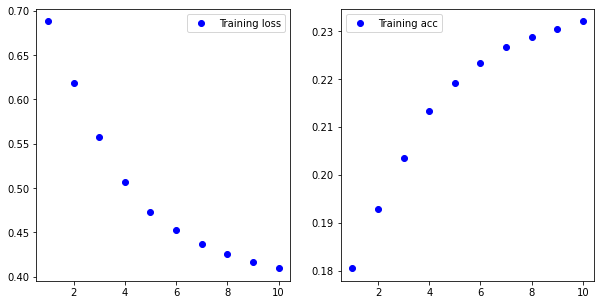

In [1]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt


2.6.0


In [2]:
os.system("mkdir -p ~/aiffel/transformer_chatbot/data/")
os.system("ln -s ~/data/* ~/aiffel/transformer_chatbot/data/")

ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv': File exists


256

In [3]:
import pandas as pd
d_path = "/aiffel/aiffel/transformer_chatbot/data/"
raw_data = pd.read_csv(d_path+"ChatbotData .csv")
raw_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
# 사용할 샘플의 최대 개수; 한국어 데이터의 규모가 작으므로 전체 사용
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [5]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거; 한국어 불필요
  # sentence = sentence.lower()
  # sentence = sentence.strip()

  # (유니코드 문자열 ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체
  # 한글은 유니코드에 포함되어 있고 낱소리만 쓰인 문자열도 포함됨
  sentence = re.sub(r'([^\w?!,])', " ", sentence)
  sentence = sentence.strip()
  
  # 구두점(punctuation)을 토큰으로 인식하도록 단어와의 사이에 공백
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  sentence = re.sub(r'[" "]+', " ", sentence)

  return sentence

In [6]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장
questions = [preprocess_sentence(s) for s in  raw_data["Q"]]
answers = [preprocess_sentence(s) for s in  raw_data["A"]]
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [7]:
# 닿소리이나 홀소리가 따로 쓰인 것도 무사히 포함된 것을 확인
print('전처리 후의 {}번째 질문 샘플: {}'.format((i:=1153)+1,questions[i]))
print('전처리 후의 {}번째 답변 샘플: {}'.format(i+2, answers[i]))

print('전처리 후의 {}번째 질문 샘플: {}'.format((i:=2104)+1,questions[i]))
print('전처리 후의 {}번째 답변 샘플: {}'.format(i+2, answers[i]))

전처리 후의 1154번째 질문 샘플: 단둘이는 처음 만나는 날ㅋㅋ
전처리 후의 1155번째 답변 샘플: 서로를 아는 좋은 기회가 되겠네요
전처리 후의 2105번째 질문 샘플: 보일러 틀고 나갔어ㅠㅠ
전처리 후의 2106번째 답변 샘플: 이번달 난방비가 많이 나오겠네요


In [8]:
# 따옴표 같은 기타 문장부호 탈락
print('전처리 후의 {}번째 질문 샘플: {}'.format((i:=6515)+1,questions[i]))
print('전처리 후의 {}번째 답변 샘플: {}'.format(i+1, answers[i]))

전처리 후의 6516번째 질문 샘플: 부르고 , 찾고 , 기도해봐도 결국은 이미 끝난 사이다
전처리 후의 6516번째 답변 샘플: 언젠간 올 이별이었을까요


In [9]:
tokens = set(w for q, a in zip(questions, answers) for w in (q+" "+a).split())
print(len(tokens))

20684


### 데이터 전처리

In [10]:
import tensorflow_datasets as tfds

In [11]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
# target_vocab_size는 대략적 토큰 수인 20000개로 설정 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                                questions + answers, target_vocab_size=20000)

In [12]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
DELIMIT_TOKEN = [tokenizer.vocab_size + 2]

print('START_TOKEN의 번호 :', START_TOKEN)
print('END_TOKEN의 번호 :', END_TOKEN)
print('DELIMIT_TOKEN의 번호 :', DELIMIT_TOKEN)

START_TOKEN의 번호 : [21935]
END_TOKEN의 번호 : [21936]
DELIMIT_TOKEN의 번호 : [21937]


In [13]:
VOCAB_SIZE = tokenizer.vocab_size + 3
print(VOCAB_SIZE)

21938


In [14]:
max_len = max(len(tokenizer.encode(q))+len(tokenizer.encode(a)) for q, a in  zip(questions, answers))
print(max_len)

30


In [15]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5206, 1368, 2623]
정수 인코딩 후의 21번째 답변 샘플: [1303, 8721, 5, 6212]


In [16]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
# 가장 긴 질문 + 답변의 길이에 시작, 종료, 구분자 토큰을 더한 길이
MAX_LENGTH = max_len + 3
print(MAX_LENGTH)

33


In [17]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs = []
  # tokenized_outputs = []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰, 종료 토큰, 구분자토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1)
    sentence2 = tokenizer.encode(sentence2) + END_TOKEN
    sentence3 = sentence1 + DELIMIT_TOKEN + sentence2

    # 최대 길이 이하인 경우에만 데이터셋으로 허용
    if len(sentence3) <= MAX_LENGTH:
      tokenized_inputs.append(sentence3)
  
  # 최대 길이로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                  tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs

In [18]:
pretrain_inputs = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 훈련 샘플 개수: {}'.format(len(pretrain_inputs)))

단어장의 크기 : 21938
필터링 후의 훈련 샘플 개수: 11823


In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
# <퀘스트> 디코더에 들어가는 한 가지 입력만 정의 
dataset = tf.data.Dataset.from_tensor_slices((
    {
#         'inputs': pretrain_inputs,
        'dec_inputs': pretrain_inputs[:, :-1]
    },
    {
        'outputs': pretrain_inputs[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 정의 및 초기화

In [138]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, np.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [95]:
# 스케일드 닷 프로덕트 어텐션 함수
# <퀘스트> 어텐션 dropout 적용, 기본갑 0.1인 rate인자 전달
def scaled_dot_product_attention(query, key, value, mask, drop_rate=0.1):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
      logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)
  # <퀘스트> 어텐션 dropout 적용
  attention_weights = tf.keras.layers.Dropout(rate=drop_rate)(attention_weights)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### 멀티헤드 어텐션

In [139]:
class MultiHeadAttention(tf.keras.layers.Layer):
  # <퀘스트> dropout rate를 초기화 인자로 전달, 기본값 0.1
  def __init__(self, d_model, num_heads, drop_rate=0.1, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)
    self.drop_rate = drop_rate

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask,
                                                              self.drop_rate)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [140]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [141]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [142]:
# 디코더 하나의 레이어를 함수로 구현.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  # <퀘스트> look_ahead_mask 함수에 패딩과 코잘 마스킹 둘 다 적용되어 있다.
  # <퀘스트> 어텐션의 drop_rate 전달
  attention1 = MultiHeadAttention(d_model, num_heads,
                                  drop_rate=dropout, name="attention_1")(
      inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask,
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization 수행
  # <퀘스트> 드랍아웃 포함
  attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1)
  attention1 = tf.keras.layers.LayerNormalization(
                  epsilon=1e-6)(attention1 + inputs)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  # <퀘스트> Feed forward 층에도 잔차연결 적용, 활성화는 relu 대신 gelu
  outputs = tf.keras.layers.Dense(units=units, activation='gelu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(
                                                        outputs + attention1)

  # <퀘스트> 디코더의 셀프 어텐션엔 한 가지 입력 텐서만 전달
  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [143]:
# 레이어 스펙을 입력받아 디코더 레이어를 반환하는 함수
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩; GPT의 경우 큰 차이 없음
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # 임베딩 층에 Dropout 적용
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # <퀘스트> 디코더의 셀프 어텐션엔 한 가지 입력 텐서만 전달
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask, padding_mask])

  # <퀘스트> 디코더의 셀프 어텐션엔 한 가지 입력 텐서만 전달
  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [144]:
def gpt(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="gpt-1"):
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # create_look_ahead_mask 함수를 디코더 어텐션 블록 입력에 맵핑
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # create_padding_mask 함수를 디코더 어텐션 블록 입력에 맵핑
  # 인코더에서 디코더로 들어오는 벡터들을 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(dec_inputs)
 
  # 디코더
  # <퀘스트> 디코더의 셀프 어텐션엔 한 가지 입력 텐서만 전달
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[dec_inputs], outputs=outputs, name=name)

In [166]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수; GPT 기본값 12 'n_layer'
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원; GPT 기본값 768 'n_embd'
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수; GPT 기본값 12 'n_head'
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기; GPT 기본값 'n_embd'*4
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt-1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    8778752     dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]        

In [167]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [168]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    # <퀘스트> 모델 저장을 위해 'get_config' 메서드 오버라이드
    config = {}
    config.update({
        'd_model': self.d_model,
        'warmup_steps': self.warmup_steps,
    })
    return config


Text(0.5, 0, 'Train Step')

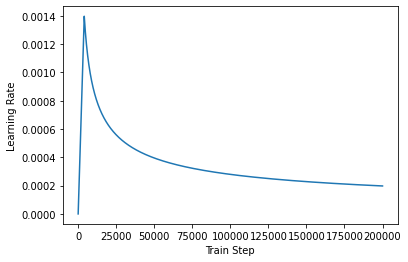

In [169]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [170]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [121]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [203]:
EPOCHS = 10
mc = ModelCheckpoint(filepath = "/aiffel/aiffel/transformer_chatbot/6Ldec_30epoch_00.ckpt",
                    monitor='accuracy', save_weights_only=True, save_best_only=True)
history = model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[mc],)

Epoch 1/10
185/185 [==============================] - 16s 86ms/step - loss: 0.6879 - accuracy: 0.1805
Epoch 2/10
185/185 [==============================] - 16s 87ms/step - loss: 0.6185 - accuracy: 0.1929
Epoch 3/10
185/185 [==============================] - 16s 87ms/step - loss: 0.5576 - accuracy: 0.2034
Epoch 4/10
185/185 [==============================] - 16s 86ms/step - loss: 0.5069 - accuracy: 0.2134
Epoch 5/10
185/185 [==============================] - 16s 86ms/step - loss: 0.4733 - accuracy: 0.2191
Epoch 6/10
185/185 [==============================] - 16s 86ms/step - loss: 0.4529 - accuracy: 0.2233
Epoch 7/10
185/185 [==============================] - 16s 87ms/step - loss: 0.4368 - accuracy: 0.2266
Epoch 8/10
185/185 [==============================] - 16s 87ms/step - loss: 0.4254 - accuracy: 0.2287
Epoch 9/10
185/185 [==============================] - 16s 86ms/step - loss: 0.4167 - accuracy: 0.2304
Epoch 10/10
185/185 [==============================] - 16s 86ms/step - loss: 0.409

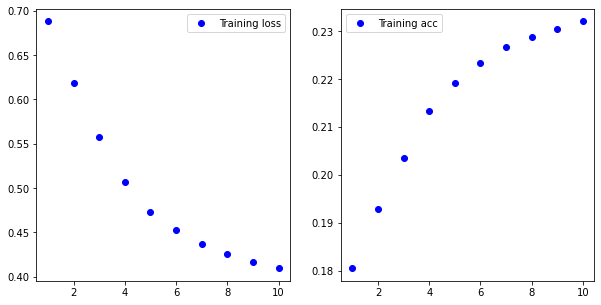

In [217]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,5))
history_dict = history.history
loss_values = history_dict["loss"]
# val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
axes[0].plot(epochs, loss_values, "bo", label="Training loss",)
# axes[0].plot(epochs, val_loss_values, "b", label="Validation loss",)
axes[0].legend()

acc = history_dict["accuracy"]
# val_acc = history_dict["val_accuracy"]
axes[1].plot(epochs, acc, "bo", label="Training acc",)
# axes[1].plot(epochs, val_acc, "b", label="Validation acc",)
axes[1].legend()
plt.show()

### 모델 테스트

In [151]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # <퀘스트> 정수 인코딩된 문장에 시작 토큰과 구분자 토큰을 앞뒤로 추가.
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + DELIMIT_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
    # <퀘스트> GPT의 디코더엔 한 가지 'sentence' 입력만 전달
    predictions = model(inputs=[sentence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 sentence와 output_sequence에 추가
    sentence = tf.concat([sentence, predicted_id], axis=-1)
                                
    # 이 output_sequence는 출력용 답변으로 반환.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [152]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [204]:
sentence_generation('어디 있었어?')

입력 : 어디 있었어?
출력 : 여행은 항상 좋죠


'여행은 항상 좋죠'

In [205]:
sentence_generation("완전 대박이네")

입력 : 완전 대박이네
출력 : 말하는 이별은 말하세요


'말하는 이별은 말하세요'

In [206]:
sentence_generation("1지망 학교 떨어졌는데 3박 4일 놀러가도 될까?")

입력 : 1지망 학교 떨어졌는데 3박 4일 놀러가도 될까?
출력 : 그런 사람들이 도움이 생각하면 된답니다


'그런 사람들이 도움이 생각하면 된답니다'

In [207]:
sentence_generation("오늘 나 완전 기분 꿀꿀한데 저녁 뭐 먹을까")

입력 : 오늘 나 완전 기분 꿀꿀한데 저녁 뭐 먹을까
출력 : 건강에 유의하세요


'건강에 유의하세요'

In [208]:
sentence_generation("오늘나완전기분꿀꿀한데저녁뭐먹을까")

입력 : 오늘나완전기분꿀꿀한데저녁뭐먹을까
출력 : 센스있는 사람으로 선택할 거예요


'센스있는 사람으로 선택할 거예요'

In [209]:
sentence_generation("오늘나완전기분꿀꿀")

입력 : 오늘나완전기분꿀꿀
출력 : 썸일 거예요


'썸일 거예요'

In [210]:
sentence_generation("오늘 나랑 밥 먹을래?")

입력 : 오늘 나랑 밥 먹을래?
출력 : 맛있는 것도 드세요


'맛있는 것도 드세요'

In [211]:
sentence_generation("오늘 나랑 lunch 먹을래?")

입력 : 오늘 나랑 lunch 먹을래?
출력 : 후회하지 않을 거예요


'후회하지 않을 거예요'

In [212]:
sentence_generation("오늘 나랑 3 먹을래?")

입력 : 오늘 나랑 3 먹을래?
출력 : 숨 쉴만 했으면 좋겠네요


'숨 쉴만 했으면 좋겠네요'

In [213]:
sentence_generation("오늘 나랑 PPL 갈래?")

입력 : 오늘 나랑 PPL 갈래?
출력 : 저는 좋아요


'저는 좋아요'

In [214]:
sentence_generation("오늘 너 좀 예쁘네")

입력 : 오늘 너 좀 예쁘네
출력 : 그런 날이 올 거예요


'그런 날이 올 거예요'

In [215]:
sentence_generation("오늴 니 쫌 이쁘네")

입력 : 오늴 니 쫌 이쁘네
출력 : 잘하고 있다고 믿어요


'잘하고 있다고 믿어요'

In [216]:
sentence_generation("썸")

입력 : 썸
출력 : 연락 패턴을 살펴보세요


'연락 패턴을 살펴보세요'

In [218]:
sentence_generation("숨 쉴만 했으면 좋겠어")

입력 : 숨 쉴만 했으면 좋겠어
출력 : 지금도 충분히 아름다워요


'지금도 충분히 아름다워요'